In [1]:
#!kaggle competitions download -c tweet-sentiment-extraction

In [59]:
import pandas as pd
import numpy as np
import os

import emoji

import matplotlib.pyplot as plt

import urllib.request

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, SimpleRNN, Flatten, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout


In [3]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/train.csv", filename="train.csv")
#train = pd.read_csv('train.csv',encoding='latin1')

train = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/train.csv", error_bad_lines=False)
test = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/test.csv", error_bad_lines=False)


In [4]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [5]:
test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

# Data exploration

## checking for null values

In [6]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
train.loc[pd.isnull(train.text)]

textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral

## drop null

In [8]:
train.dropna(inplace=True)

## count of unique values

In [9]:
train.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [10]:
train.shape, test.shape

((27480, 4), (3534, 3))

In [11]:
train.pivot_table(index='sentiment', values='textID', 
                  aggfunc='count', margins=True)


textID
sentiment        
negative     7781
neutral     11117
positive     8582
All         27480

In [12]:
train.pivot_table(index='sentiment', values='textID', 
                 aggfunc = lambda x: x.count()/train['sentiment'].count())


textID
sentiment          
negative   0.283151
neutral    0.404549
positive   0.312300

# Feature engineering

## URL 

In [13]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [14]:
train['url']=train['text'].apply(lambda x:find_url(x))

In [15]:
train.loc[pd.notnull(train.url)]

textID                                               text  \
5      28b57f3990  http://www.dothebouncy.com/smf - some shameles...   
17     919fa93391  i`ve been sick for the past few days  and thus...   
35     4f5267ad70  Thats it, its the end. Tears for Fears vs Eric...   
50     a3ae670885   Then you should check out http://twittersucks...   
57     6086b1f016      will be back later.  http://plurk.com/p/rp3k7   
...           ...                                                ...   
27374  b49385ebb7   says Finally, Im home.  http://plurk.com/p/rr121   
27384  f94af8cb85  This is a much better tool than some I have co...   
27386  e149ebd3a1  #vwll2009 Would one of the VWLLers want to add...   
27463  a38bf809b0   LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...   
27472  8f5adc47ec  http://twitpic.com/663vr - Wanted to visit the...   

                                           selected_text sentiment  \
5      http://www.dothebouncy.com/smf - some shameles...   neutral   
17                                                  sick  negative   
35                Thats it, its the end. Tears for Fears   neutral   
50     Then you should check out http://twittersucks....   neutral   
57                                   will be back later.   neutral   
...                                                  ...       ...   
27374                             says Finally, Im home.   neutral   
27384                         This is a much better tool  positive   
27386                                       ch appreciat  positive   
27463                                               MISS  negative   
27472                                      were too late  negative   

                                  url  
5      http://www.dothebouncy.com/smf  
17          http://tinyurl.com/mnf4kw  
35               http://bit.ly/2Hpbg4  
50            http://twittersucks.com  
57           http://plurk.com/p/rp3k7  
...                               ...  
27374        http://plurk.com/p/rr121  
27384        http://www.tweepular.com  
27386             http://bit.ly/BF5sh  
27463             http://bit.ly/r6RfC  
27472        http://twitpic.com/663vr  

[1221 rows x 5 columns]

## Emoticons

In [16]:
ex = "😍 lol 😆 😂 "
emoji.demojize(ex)

':smiling_face_with_heart-eyes: lol :grinning_squinting_face: :face_with_tears_of_joy: '

In [17]:
re.findall(':(.*?):', emoji.demojize(ex) )  #<-mac
#re.findall( r'\:(.*?)\:', emoji.demojize(ex) )  <- window

['smiling_face_with_heart-eyes',
 'grinning_squinting_face',
 'face_with_tears_of_joy']

emoji.UNICODE_EMOJI

In [18]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

In [19]:
extract_emojis( "😊😳😏😁")

'😊😳😏😁'

In [20]:
extract_emojis('text without emojis')

In [21]:
train['emoji']=train['text'].apply(lambda x: extract_emojis(x))

In [22]:
train.loc[pd.notnull(train.emoji)]

Empty DataFrame
Columns: [textID, text, selected_text, sentiment, url, emoji]
Index: []

In [23]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment   url emoji  
0  I`d have responded, if I were going   neutral  None  None  
1                             Sooo SAD  negative  None  None  
2                          bullying me  negative  None  None  
3                       leave me alone  negative  None  None  
4                        Sons of ****,  negative  None  None

## Text preparation

### stopwords: words which does not add much meaning to a sentence

In [24]:
#nltk.download('stopwords') <- if error raises on nltk stopwords

stops = set(stopwords.words('english'))
#stops

### stem extraction - Lemmatizing words

In [25]:
words =['fly', 'flies', 'flew', 'flown']

In [26]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

#types of stemmers
stemmerS = SnowballStemmer('english')  
stemmerP = PorterStemmer()
stemmerL = LancasterStemmer()

In [27]:
OutputSnowball=[stemmerS.stem(word) for word in words]
OutputPorter=[stemmerP.stem(word) for word in words]
OutputLancaster=[stemmerL.stem(word) for word in words]

print("using Snowball stemmer: ", OutputSnowball)
print("using Porter stemmer: ", OutputPorter)
print("using Lancaster stemmer: ", OutputLancaster)

using Snowball stemmer:  ['fli', 'fli', 'flew', 'flown']
using Porter stemmer:  ['fli', 'fli', 'flew', 'flown']
using Lancaster stemmer:  ['fly', 'fli', 'flew', 'flown']


In [28]:
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
#nltk.download('wordnet')

In [29]:
Output=[lm.lemmatize(word, pos="v") for word in words]
print("using Lemmatizer: " , Output)

using Lemmatizer:  ['fly', 'fly', 'fly', 'fly']


# Tokenizer

In [30]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)
    

In [31]:
train['text processed'] = train['text'].apply(lambda x: language_preprocessor(x)) 


In [32]:
train.head(3)

textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                       my boss is bullying me...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   

                  text processed  
0             [responded, going]  
1  [sooo, sad, miss, san, diego]  
2                [bos, bullying]

# Commonly used words for each sentiment type

In [33]:
positive = train[train.sentiment=='positive']
negative = train[train.sentiment=='negative']
neutral = train[train.sentiment=='neutral']

In [34]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

## positive

In [35]:
common_words_positive  = common_words(positive, 'text processed', 10)
common_words_positive

Word  count
0     day   1375
1    good   1068
2    love    950
3   happy    858
4  mother    677
5  thanks    570
6   great    483
7       u    447
8    like    434
9    hope    417

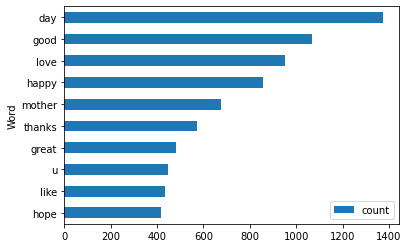

In [36]:
common_words_positive.set_index('Word').sort_values(
    by='count', ascending=True).plot(kind='barh')

In [37]:
import plotly.express as px

px.treemap(common_words_positive, 
           path=['Word'], values='count',
           title='Most commonly used Positive Words',
          width=400, height=400)

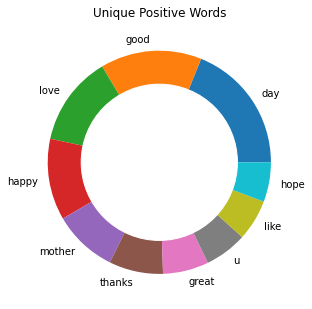

In [38]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(5,7))
my_circle=plt.Circle((0,0), 0.7, color='white')


plt.pie(common_words_positive['count'], 
        labels=common_words_positive.Word) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words')
plt.show()

### visualization with word cloud

In [39]:
common_words_positive  = common_words(positive, 'text processed', 100)

In [40]:
common_words_positive.set_index("Word")['count']

Word
day       1375
good      1068
love       950
happy      858
mother     677
          ... 
sleep      104
x          103
bit        103
people     103
gonna      102
Name: count, Length: 100, dtype: int64

In [41]:
words = common_words_positive.set_index("Word")['count'].to_dict()
words

{'day': 1375,
 'good': 1068,
 'love': 950,
 'happy': 858,
 'mother': 677,
 'thanks': 570,
 'great': 483,
 'u': 447,
 'like': 434,
 'hope': 417,
 'http': 414,
 'get': 392,
 'today': 360,
 'lol': 359,
 'fun': 352,
 'time': 349,
 'night': 347,
 'nice': 339,
 'one': 324,
 'go': 317,
 'really': 309,
 'got': 307,
 'morning': 298,
 'com': 294,
 'going': 286,
 'wish': 285,
 'awesome': 279,
 'mom': 279,
 'see': 276,
 'new': 275,
 'work': 273,
 'know': 262,
 'well': 260,
 'haha': 257,
 'back': 254,
 'much': 254,
 'thank': 249,
 'better': 221,
 'best': 221,
 'oh': 210,
 'would': 205,
 'home': 202,
 'im': 200,
 'think': 200,
 'make': 198,
 'look': 185,
 'twitter': 178,
 'cool': 176,
 'want': 176,
 'amazing': 174,
 'tonight': 171,
 'friend': 168,
 'tomorrow': 168,
 'last': 167,
 'weekend': 166,
 'still': 157,
 'though': 154,
 'week': 153,
 'thing': 153,
 'could': 150,
 'everyone': 146,
 'wait': 142,
 'say': 142,
 'come': 142,
 'guy': 141,
 'yay': 140,
 'need': 138,
 'right': 138,
 'twitpic': 134,
 

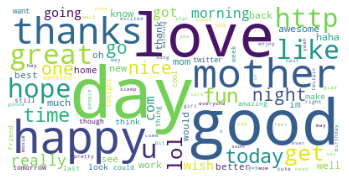

In [42]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=400, height=200)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## negative

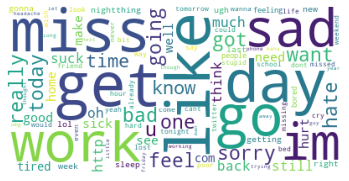

In [43]:
common_words_negative  = common_words(negative, 'text processed', 100)
words_negative = common_words_negative.set_index("Word")['count'].to_dict()

wordcloud = wc.generate_from_frequencies(words_negative)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

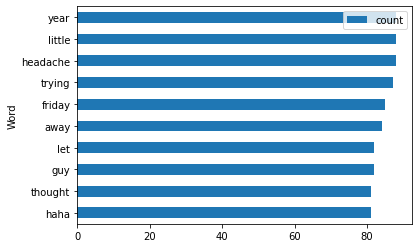

In [44]:
common_words_negative.set_index('Word').sort_values(
    by='count', ascending=True).head(10).plot(kind='barh')

# Vectorizing text.

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   textID          27480 non-null  object
 1   text            27480 non-null  object
 2   selected_text   27480 non-null  object
 3   sentiment       27480 non-null  object
 4   url             1221 non-null   object
 5   emoji           0 non-null      object
 6   text processed  27480 non-null  object
dtypes: object(7)
memory usage: 2.9+ MB


In [46]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   
3                       leave me alone  negative  None  None   
4                        Sons of ****,  negative  None  None   

                         text processed  
0                    [responded, going]  
1         [sooo, sad, miss, san, diego]  
2                       [bos, bullying]  
3             [interview, leave, alone]  
4  [son, put, release, already, bought]

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() #oov_token="<OOV>") #num_words=1000)
tokenizer.fit_on_texts(train['text processed'])

In [48]:
print(tokenizer.word_index)

{'day': 1, 'good': 2, 'get': 3, 'like': 4, 'go': 5, 'http': 6, 'u': 7, 'love': 8, 'work': 9, 'today': 10, 'going': 11, 'time': 12, 'got': 13, 'one': 14, 'lol': 15, 'happy': 16, 'know': 17, 'back': 18, 'really': 19, 'com': 20, 'im': 21, 'want': 22, 'see': 23, 'night': 24, 'mother': 25, 'think': 26, 'new': 27, 'home': 28, 'well': 29, 'still': 30, 'oh': 31, 'thanks': 32, 'much': 33, 'need': 34, 'miss': 35, 'hope': 36, 'great': 37, 'make': 38, 'feel': 39, 'last': 40, 'morning': 41, 'haha': 42, 'wish': 43, 'week': 44, 'twitter': 45, 'fun': 46, 'tomorrow': 47, 'would': 48, 'thing': 49, 'sorry': 50, 'tonight': 51, 'sad': 52, 'bad': 53, 'come': 54, 'look': 55, 'right': 56, 'friend': 57, 'yeah': 58, 'gonna': 59, 'say': 60, 'nice': 61, 'though': 62, 'mom': 63, 'way': 64, 'sleep': 65, 'better': 66, 'weekend': 67, 'could': 68, 'bit': 69, 'getting': 70, 'bed': 71, 'people': 72, 'hour': 73, 'hate': 74, 'next': 75, 'twitpic': 76, 'school': 77, 'guy': 78, 'show': 79, 'dont': 80, 'watching': 81, 'wait'

In [49]:
vocab_size = len(tokenizer.word_index) +1

In [50]:
X_data = train['text processed']
X_data

0                                       [responded, going]
1                            [sooo, sad, miss, san, diego]
2                                          [bos, bullying]
3                                [interview, leave, alone]
4                     [son, put, release, already, bought]
                               ...                        
27476    [wish, could, come, see, u, denver, husband, l...
27477    [wondered, rake, client, made, clear, net, for...
27478    [yay, good, enjoy, break, probably, need, hect...
27479                                              [worth]
27480              [flirting, going, atg, smile, yay, hug]
Name: text processed, Length: 27480, dtype: object

In [51]:
x_train = tokenizer.texts_to_sequences(X_data)
#x_train = np.asarray(x_train)
x_train = np.asarray(x_train)

In [52]:
x_train

array([list([9249, 11]), list([306, 52, 35, 1298, 2076]),
       list([1193, 9250]), ...,
       list([143, 2, 244, 352, 281, 34, 3509, 67, 90, 496, 731, 2580]),
       list([569]), list([5699, 11, 22559, 562, 143, 333])], dtype=object)

In [53]:
max_len = max(len(item) for item in x_train)
print(max_len)

25


In [54]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
np.asarray(x_train)

array([[ 9249,    11,     0, ...,     0,     0,     0],
       [  306,    52,    35, ...,     0,     0,     0],
       [ 1193,  9250,     0, ...,     0,     0,     0],
       ...,
       [  143,     2,   244, ...,     0,     0,     0],
       [  569,     0,     0, ...,     0,     0,     0],
       [ 5699,    11, 22559, ...,     0,     0,     0]], dtype=int32)

from tensorflow.keras.utils import to_categorical
x_train = to_categorical(x_train)
x_train

y_train = train.sentiment.replace({"neutral":0, 'positive': 1, 'negative':-1})
y_train = y_train.values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train.sentiment)

enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

y_train = onehot_encoded

from keras.utils import to_categorical
to_categorical(integer_encoded)

In [60]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train.sentiment)
encoded_Y = encoder.transform(train.sentiment)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)

In [61]:
x_train.shape, y_train.shape

((27480, 25), (27480, 3))

In [62]:
len(x_train[0])

25

In [81]:
#define the model
model = Sequential()
model.add(Embedding(vocab_size, 50))
model.add(SimpleRNN(10))
model.add(Dense(10, input_dim=x_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='sigmoid'))

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, epochs=15, batch_size=5000, verbose=2)

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/15
 - 2s - loss: 1.1028 - accuracy: 0.3527
Epoch 2/15
 - 1s - loss: 1.0796 - accuracy: 0.4049
Epoch 3/15
 - 1s - loss: 1.0698 - accuracy: 0.4074
Epoch 4/15
 - 1s - loss: 1.0496 - accuracy: 0.4525
Epoch 5/15
 - 1s - loss: 1.0218 - accuracy: 0.5401
Epoch 6/15
 - 1s - loss: 0.9834 - accuracy: 0.5863
Epoch 7/15
 - 1s - loss: 0.9340 - accuracy: 0.6433
Epoch 8/15
 - 1s - loss: 0.8830 - accuracy: 0.7043
Epoch 9/15
 - 1s - loss: 0.8366 - accuracy: 0.7112
Epoch 10/15
 - 1s - loss: 0.7969 - accuracy: 0.7182
Epoch 11/15
 - 1s - loss: 0.7615 - accuracy: 0.7333
Epoch 12/15
 - 1s - loss: 0.7294 - accuracy: 0.7601
Epoch 13/15
 - 1s - loss: 0.6986 - accuracy: 0.7837
Epoch 14/15
 - 1s - loss: 0.6697 - accuracy: 0.7987
Epoch 15/15
 - 1s - loss: 0.6412 - accuracy: 0.8171


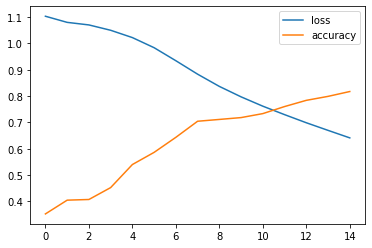

In [82]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [83]:
# evaluate the keras model
_, accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 82.67




# define baseline model
def baseline_model():
    #model architecture)
    #input_tensor = Input(shape=(27480, 10 ))
    model = Sequential()
    model.add(Embedding(vocab_size, 50))
    model.add(SimpleRNN(7))
    #model.add(Dense(5, activation="relu", kernel_initializer="uniform") )
    #model.add(Dense(5, input_dim=5, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(5, activation="relu", kernel_initializer="uniform", input_shape=((5,  )) ))
#model.add(Dense(5, input_dim=5, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation='sigmoid'))

In [72]:
y_train.shape, x_train.shape

((27480, 3), (27480, 25))




estimator = KerasClassifier(build_fn=baseline_model, epochs=4, batch_size=5000, verbose=1)
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)


print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=15, batch_size=5000, verbose=0)

results = model.evaluate(x_train, y_train)
results

loss_score, accuracy_score = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Loss Score: {:.2f}'.format(loss_score))
print('Train Accuracy Score: {:.2f}%'.format(accuracy_score*100))

In [84]:
def predict_sentiment(text):
    text = language_preprocessor(text)
    tokenizer.fit_on_texts(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_len, padding='post', truncating='post')
    #return text
    predict = model.predict(text)
    predict = predict.argmax(axis=-1)
    #predict_labels = np.argmax(predict, axis=1) 
    return predict

In [85]:
test_text = "i really love it! it is such a great day"

In [86]:
predict_sentiment(test_text)

array([0])

test['prediction']=test['text'].apply(lambda x: predict_sentiment(x))